In [2]:
import os
from dataclasses import asdict, dataclass

from lightning.pytorch import Trainer, callbacks, seed_everything
from lightning.pytorch.loggers import WandbLogger

from src import DEVICE
from src.data.data_module import DepthEstimationDataModule
from src.models import Unet3Plus
from src.train import losses
from src.train import (
    LightningModel,
    ModelCheckpoint,
    VisualizePrediction,
    get_lr_scheduler_kwargs,
    transforms,
)
from src.utils import download_dataset

seed_everything(42)

ModuleNotFoundError: No module named 'matplotlib'

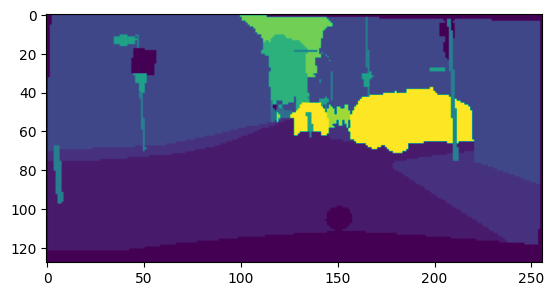

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
temp = torch.Tensor(np.arange(400).reshape((10,10,4)))
mask = torch.Tensor(np.repeat(np.eye(10).reshape(*temp.shape[:2],1),4,axis=-1)).bool()
torch.masked_select(temp,mask).reshape(-1,4)
plt.imshow(np.load("/Users/maciej.filanowicz/monocular-depth-estimation/data/data/val/label/0.npy"))

In [ ]:
@dataclass
class Config:
    data_dir = "../data"
    batch_size: int = 1
    classes: int = 19
    num_workers: int = os.cpu_count()
    encoder_name: str = "tf_efficientnetv2_m.in21k_ft_in1k"
    decoder_attention_type: str = "scse"
    head_activation_name: str = "sigmoid"
    optimizer: str = "Adam"
    learning_rate: float = 1e-4
    accumulate_grad_batches: int = 1
    depth_loss_function_name: str = "L1Loss"
    seg_loss_function_name: str = "FocalLoss"
    gamma: float = 1.0
    alpha: float = 0.5
    wandb_project_name: str = "depth-estimation"
config = Config()

In [ ]:
download_dataset(destination_path=config.data_dir)

In [ ]:
config.data_dir = os.path.join(config.data_dir,"data") #TODO fix zip file in gdrive

In [ ]:
data_module = DepthEstimationDataModule(
    data_dir=config.data_dir, batch_size=config.batch_size, num_workers=config.num_workers, transforms=transforms
)
data_module.setup()

In [ ]:
lr_scheduler_kwargs = get_lr_scheduler_kwargs(
    data_dir=os.path.join(config.data_dir, "train", "image"),
    batch_size=config.batch_size,
    accumulate_grad_batches=config.accumulate_grad_batches,
)
data_module = DepthEstimationDataModule(
    data_dir=config.data_dir, batch_size=config.batch_size, num_workers=config.num_workers, transforms=transforms
)
data_module.setup()
model = Unet3Plus(
    encoder_name=config.encoder_name,
    classes=config.classes,
    activation=config.head_activation_name,
    decoder_attention_type=config.decoder_attention_type,
)

lightning_model = LightningModel(
    model=model,
    optimizer=config.optimizer,
    learning_rate=config.learning_rate,
    depth_loss=getattr(losses,config.depth_loss_function_name)(ignore_values=0, reduction="sum"),
    segmentation_loss=getattr(losses,config.seg_loss_function_name)(ignore_values=-1,gamma=config.gamma,alpha=config.alpha),
    lr_scheduler_params=lr_scheduler_kwargs,
)
wandb_logger = WandbLogger(project=config.wandb_project_name, config=asdict(config), reinit=True, log_model="all")
checkpoint_callback = ModelCheckpoint(
    save_top_k=2,
    monitor=f"Validation/{config.depth_loss_function_name}",
    filename="{epoch:02d}-{Validation_" + config.depth_loss_function_name + ":.2f}",
)
trainer = Trainer(
    accelerator=DEVICE,
    logger=wandb_logger,
    max_epochs=1,
    num_sanity_val_steps=1,
    gradient_clip_val=1.0,
    log_every_n_steps=1,
    accumulate_grad_batches=config.accumulate_grad_batches,
    enable_progress_bar=True,
    enable_checkpointing=True,
    callbacks=[
        checkpoint_callback,
        callbacks.LearningRateMonitor(logging_interval="step"),
        VisualizePrediction()
    ],
)


In [ ]:
trainer.fit(lightning_model, data_module)